In [ ]:
sc.install_pypi_package( "pandas==1.0.4" )
sc.install_pypi_package( "matplotlib==3.2.1" )
sc.install_pypi_package("imblearn==0.0")
sc.install_pypi_package("scikit-learn==0.23.1")
sc.install_pypi_package("sklearn==0.0")
sc.install_pypi_package("boto3==1.13")

In [2]:
import sys
import pandas as pd
from pyspark.sql import SparkSession
# create sparksession
spark = SparkSession \
    .builder \
    .appName("insight") \
    .getOrCreate()
acquis = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q1/Acquisition_2010Q1.txt")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
perf = spark.read.option("inferSchema", "true").option("header", False).option("dateFormat", "yyyyMMdd").option("delimiter","|").csv("s3://default-data/2010Q1/Performance_2010Q1.txt")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
col_names_aquisition = ['loanID', 'originationChannel', 'sellerName', 'origIntRate', 'origUPB', 
                       'origLoanTerm', 'originationDate', 'firstPaymentDate', 'LTV', 'CLTV', 
                        'numOfBorrowers', 'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination',
                       'firstTimeBuyerIndicator', 'loanPurpose', 'propertyType', 'numOfUnits',
                       'occupancyType', 'propertyState', 'zipCodeShort', 'primaryMortgInsurPercent', 
                       'productType', 'coborrowerCreditScoreAtOrig', 'mortgageInsurType', 
                       'relocationMortgIndicator']
col_names_performance =['loanID', 'monthlyReportingPeriod', 'servicerName', 'currentIntRate',
                       'currentActualUPB', 'loanAge', 'remMonthsToLegalMaturity', 'adjMonthToMaturity',
                       'maturityDate', 'MSA', 'currentLoanDelinqStatus', 'modifFlag', 'zeroBalanceCode',
                       'zeroBalanceEffectiveDate', 'lastPaidInstallDate', 'foreclosureDate',
                       'dispositionDate', 'foreclosureCost', 'propPreservAndReparCosts', 'assetRecoveryCosts',
                       'miscelHoldingExpensesAndCredits', 'associatedTaxesForHoldingProperty', 'netSaleProceeds',
                       'creditEnhacementProceeds', 'repurchaseMakeWholeProceeds','otherForeclosureProceeds',
                       'nonInterestBearingUPB', 'principalForegivenessAmount', 'repurchaseMakeWholeProceedsFlag',
                       'foreclosurePrincipWriteOffAmont', 'servicingActivityIndicator']



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
from pyspark.sql.functions import col
#acquis_rn.where(col('loanID')==100019943199).show()
#perf_rn.where(col('loanID')==100446401716).select(['loanID', 'modifFlag','monthlyReportingPeriod','zeroBalanceCode', 'currentLoanDelinqStatus', 'foreclosureDate']).show(50)
#perf_rn.where(col('currentLoanDelinqStatus').isNull()).select(['loanID', 'monthlyReportingPeriod','zeroBalanceCode', 'currentLoanDelinqStatus']).show(4)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
i = 0
acquis_rn = acquis
for colname in col_names_aquisition:
    acquis_rn = acquis_rn.withColumnRenamed("_c"+str(i),col_names_aquisition[i])
    i = i + 1
    
i = 0
perf_rn = perf
for colname in col_names_performance:
    perf_rn = perf_rn.withColumnRenamed("_c"+str(i),col_names_performance[i])
    i = i + 1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.sql.functions import to_date
from pyspark.sql.types import IntegerType
perf_rn = perf_rn.withColumn("monthlyReportingPeriod",to_date(perf_rn.monthlyReportingPeriod,'MM/dd/yyyy'))
perf_rn = perf_rn.withColumn("currentLoanDelinqStatus", perf_rn["currentLoanDelinqStatus"].cast(IntegerType()))
acquis_rn = acquis_rn.withColumn("originationDate",to_date(acquis_rn.originationDate,'MM/yyyy'))
acquis_rn = acquis_rn.withColumn("firstPaymentDate",to_date(acquis_rn.firstPaymentDate,'MM/yyyy'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
print(acquis_rn.count(), len(acquis_rn.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

323174 25

In [9]:
perf_rn.createOrReplaceTempView('perf')
_2010Q1_perf = spark.sql(
'''
SELECT 
perf.loanID, perf.monthlyReportingPeriod, perf.zeroBalanceCode, perf.currentLoanDelinqStatus FROM perf 

'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
classes = _2010Q1_perf.groupBy("loanID").max("zeroBalanceCode").withColumnRenamed("max(zeroBalanceCode)", "code")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
classes.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- loanID: long (nullable = true)
 |-- code: integer (nullable = true)

In [12]:
a = classes.groupBy("code").count().sort("code")
a.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|null| 56988|
|   1|263793|
|   2|   245|
|   3|   268|
|   6|   284|
|   9|  1167|
|  15|   174|
|  16|   255|
+----+------+

In [13]:
from pyspark.sql.functions import when, col

classes1 = classes.withColumn("code", when(classes.code.isNull(), 0).otherwise(classes.code))
classes1.groupBy("code").count().sort("code").show(20)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0| 56988|
|   1|263793|
|   2|   245|
|   3|   268|
|   6|   284|
|   9|  1167|
|  15|   174|
|  16|   255|
+----+------+

In [14]:
classes1 = classes1.filter((classes1.code!= 6) & (classes1.code!= 15) & (classes1.code!= 16))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
classes1=classes1.replace((2,3),9)
df1 = classes1.groupBy("code").count().sort("code")
df1.show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+------+
|code| count|
+----+------+
|   0| 56988|
|   1|263793|
|   9|  1680|
+----+------+

In [16]:
acquis_rn.createOrReplaceTempView('acquis')
sql_acquis = spark.sql(
'''
SELECT acquis.loanID, acquis.originationChannel, acquis.sellerName, acquis.origIntRate, acquis.origUPB, acquis.originationDate, 
acquis.firstPaymentDate, acquis.LTV, acquis.CLTV, acquis.numOfBorrowers, acquis.origDebtToIncomeRatio, 
acquis.borrowerCredScoreAtOrigination, acquis.firstTimeBuyerIndicator, acquis.loanPurpose, acquis.propertyType, 
acquis.numOfUnits, acquis.zipCodeShort, acquis.primaryMortgInsurPercent, acquis.productType, acquis.mortgageInsurType
FROM acquis

'''
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
_2010Q1 = sql_acquis.join(classes1,on=['loanID'],how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
_2010Q1.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['loanID', 'originationChannel', 'sellerName', 'origIntRate', 'origUPB', 'originationDate', 'firstPaymentDate', 'LTV', 'CLTV', 'numOfBorrowers', 'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination', 'firstTimeBuyerIndicator', 'loanPurpose', 'propertyType', 'numOfUnits', 'zipCodeShort', 'primaryMortgInsurPercent', 'productType', 'mortgageInsurType', 'code']

In [19]:
print(_2010Q1.count(), len(_2010Q1.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

322461 21

In [20]:
_cols = _2010Q1.columns
_2010Q1_cleaned = _2010Q1
for _c in _cols:
    count = _2010Q1_cleaned.where(_2010Q1_cleaned[_c]. isNull()).count()
    print(f"{_c}: {count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loanID: 0
originationChannel: 0
sellerName: 0
origIntRate: 0
origUPB: 0
originationDate: 0
firstPaymentDate: 0
LTV: 0
CLTV: 11
numOfBorrowers: 2
origDebtToIncomeRatio: 2717
borrowerCredScoreAtOrigination: 296
firstTimeBuyerIndicator: 0
loanPurpose: 0
propertyType: 0
numOfUnits: 0
zipCodeShort: 0
primaryMortgInsurPercent: 303125
productType: 0
mortgageInsurType: 303125
code: 0

In [21]:
drop1= ['primaryMortgInsurPercent', 'mortgageInsurType']
_2010Q1 = _2010Q1.drop(*drop1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
print(_2010Q1.count(), len(_2010Q1.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

322461 19

In [23]:
_cols = _2010Q1.columns
_2010Q1_cleaned = _2010Q1
for _c in _cols:
    count = _2010Q1_cleaned.where(_2010Q1_cleaned[_c]. isNull()).count()
    print(f"{_c}: {count}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loanID: 0
originationChannel: 0
sellerName: 0
origIntRate: 0
origUPB: 0
originationDate: 0
firstPaymentDate: 0
LTV: 0
CLTV: 11
numOfBorrowers: 2
origDebtToIncomeRatio: 2717
borrowerCredScoreAtOrigination: 296
firstTimeBuyerIndicator: 0
loanPurpose: 0
propertyType: 0
numOfUnits: 0
zipCodeShort: 0
productType: 0
code: 0

In [24]:
_cols = _2010Q1.columns
_2010Q1_cleaned = _2010Q1
for _c in _cols:
    _2010Q1_cleaned = _2010Q1_cleaned.filter(_2010Q1_cleaned[_c]. isNotNull())
print(_2010Q1_cleaned.count(), len(_2010Q1_cleaned.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

319445 19

In [25]:
drop2=["loanID","originationDate", "firstPaymentDate"]
_2010Q1_cleaned = _2010Q1_cleaned.drop(*drop2) 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
_2010Q1_cleaned.select(_2010Q1_cleaned.columns[0:8]).show(7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+-----------+-------+---+----+--------------+---------------------+
|originationChannel|          sellerName|origIntRate|origUPB|LTV|CLTV|numOfBorrowers|origDebtToIncomeRatio|
+------------------+--------------------+-----------+-------+---+----+--------------+---------------------+
|                 R|JPMORGAN CHASE BA...|      4.875|  77000| 51|  51|             1|                   37|
|                 R|WELLS FARGO BANK,...|      4.875| 600000| 65|  65|             2|                   23|
|                 C|WELLS FARGO BANK,...|      4.875| 161000| 75|  75|             1|                   54|
|                 C|               OTHER|      4.875| 262000| 90|  90|             2|                   36|
|                 C|BANK OF AMERICA, ...|      4.875| 288000| 71|  71|             1|                   31|
|                 R|  CITIMORTGAGE, INC.|        4.5| 189000| 25|  25|             2|                   31|
|                 C|JPMORGAN

In [27]:
_2010Q1_cleaned.select(_2010Q1_cleaned.columns[8:14]).show(7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------------------+-----------------------+-----------+------------+----------+------------+
|borrowerCredScoreAtOrigination|firstTimeBuyerIndicator|loanPurpose|propertyType|numOfUnits|zipCodeShort|
+------------------------------+-----------------------+-----------+------------+----------+------------+
|                           796|                      N|          C|          SF|         1|         949|
|                           781|                      N|          R|          PU|         1|         950|
|                           784|                      N|          C|          SF|         1|         530|
|                           725|                      N|          R|          SF|         1|         109|
|                           809|                      N|          P|          SF|         1|          78|
|                           791|                      N|          C|          SF|         1|         981|
|                           708|              

In [28]:
_2010Q1_cleaned.select(_2010Q1_cleaned.columns[14:20]).show(7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----+
|productType|code|
+-----------+----+
|        FRM|   1|
|        FRM|   1|
|        FRM|   0|
|        FRM|   0|
|        FRM|   1|
|        FRM|   0|
|        FRM|   0|
+-----------+----+
only showing top 7 rows

In [29]:
from imblearn.over_sampling import SMOTENC
from collections import Counter
_2010Q1_cleanedPandas =_2010Q1_cleaned.toPandas()
y = _2010Q1_cleanedPandas['code'].values
X = _2010Q1_cleanedPandas.drop(['code'], axis=1).values
smote_nc = SMOTENC(categorical_features=[0, 1, 9, 10, 11,14], random_state=0)
X_resampled, y_resampled = smote_nc.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0, 261338), (1, 261338), (9, 261338)]

In [30]:
X = pd.DataFrame(data=X_resampled, index=None, columns=['originationChannel', 'sellerName', 'origIntRate', 
                                                        'origUPB', 'LTV', 'CLTV', 'numOfBorrowers', 
                                                        'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination', 
                                                        'firstTimeBuyerIndicator', 'loanPurpose', 'propertyType', 
                                                        'numOfUnits', 'zipCodeShort', 'productType'])
y=pd.Series(y_resampled)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np

rng = np.random.RandomState(seed=42)


categorical_columns = ['originationChannel', 'sellerName', 'firstTimeBuyerIndicator',
                      'loanPurpose', 'propertyType', 'productType']
numerical_columns = ['origIntRate', 'origUPB', 'LTV', 'CLTV', 'numOfBorrowers', 
                     'origDebtToIncomeRatio', 'borrowerCredScoreAtOrigination', 
                     'numOfUnits','zipCodeShort']

X1 = X[categorical_columns + numerical_columns]
y1=y

#spliting of data into test and train
X1_train, X1_test, y_train, y_test = train_test_split(
    X1, y1, stratify=y, test_size = 0.25, random_state=42)
#pipeline for one-hot encoding of categorical features
categorical_pipe = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#imputer in case value is missing from numerical feature
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])
#processing data
preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])
#setting up the model
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
rf.fit(X1_train, y_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['originationChannel',
                                                   'sellerName',
                                                   'firstTimeBuyerIndicator',
                                                   'loanPurpose',
                                                   'propertyType',
                                                   'productType']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['origIntRate', 'origUPB',
         

In [33]:
print("RF train accuracy: %0.3f" % rf.score(X1_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X1_test, y_test))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RF train accuracy: 1.000
RF test accuracy: 0.876

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

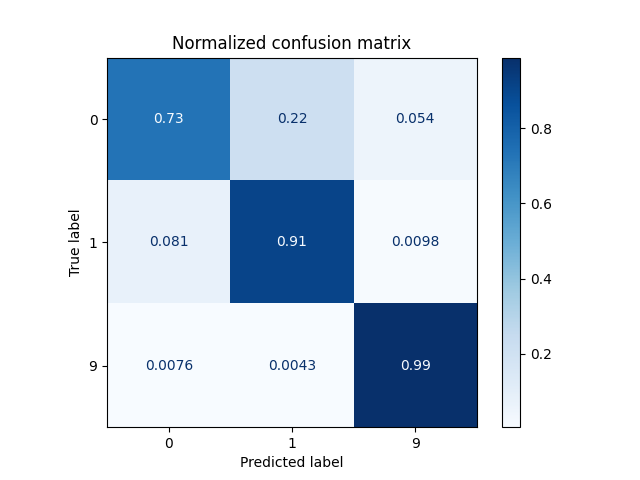

In [34]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
class_names = [0,1,9]
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, X1_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

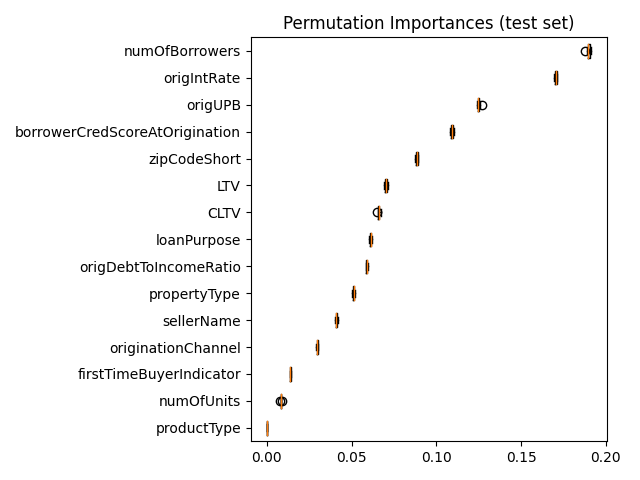

In [36]:
import matplotlib
import matplotlib.pyplot as plt

result = permutation_importance(rf, X1_test, y_test.to_numpy(), n_repeats=10,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X1_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
%matplot plt

In [ ]:
import tempfile
import boto3
import joblib
bucket_name = "mortgagemodel"
key = "model2rf.pkl"
client = boto3.client('s3')
client.create_bucket(Bucket=bucket_name)
with tempfile.TemporaryFile() as fp:
    joblib.dump(rf, fp)
    fp.seek(0)
    client.put_object(Body=fp.read(), Bucket=bucket_name, Key=key)